In [4]:
import torch
import torchvision

import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from typing import *
import h5py

In [5]:
import sys
sys.path.append('patch_attack_on_object_detectors/utils/')
from patch_attack_on_object_detectors.utils.visualize_utils import draw_bbox_with_tensor, DataVisualizer, show

In [6]:
device = 'cuda'

In [9]:
x = torch.rand((3, 100, 100), device='cuda')
i = torch.tensor([[1, 2], [3, 4]], dtype=torch.long)
x[:, i[0], i[1]]

tensor([[0.8367, 0.8939],
        [0.9574, 0.5993],
        [0.3761, 0.6018]], device='cuda:0')

In [10]:
def fasterrcnn_resnet50_fpn_Carla():
    # well, typical detection network works perfectly, efficiently here.
    pretrained_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    )
    out_channels = pretrained_model.backbone(torch.rand(1, 3, 1, 1))['0'].shape[1]
    # we've actually known the rough shape of region, so we can actually improve anchor generation strategy
    

    defaults = {
        "min_size": 720,
        "max_size": 1080,
        "rpn_pre_nms_top_n_test": 100,
        "rpn_post_nms_top_n_test": 50,
        "rpn_pre_nms_top_n_train": 100,
        "rpn_post_nms_top_n_train": 50,
        "rpn_score_thresh": 0.05,
        "box_nms_thresh": 0.2
    }
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.anchor_utils import AnchorGenerator
    
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes) 
    
    anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
    
    class DummyBackbone(torch.nn.Module):
        # to fool FasterRCNN class, because Faster RCNN requires a backbone network with attribute 'out_channels'
        def __init__(self, out_channels):
            super().__init__()
            self.out_channels = out_channels

    my_model = FasterRCNN(DummyBackbone(out_channels),
                          num_classes=5,
                          rpn_anchor_generator=anchor_generator,
                          **defaults
                          )
    # use backbone in pretrained faster rcnn model directly
    # skip complicated steps in building a backbone with FPN.
    my_model.backbone = pretrained_model.backbone
    
    for module in my_model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.track_running_stats = False
            
    return my_model

In [11]:
class CarlaDS(Dataset):
    labels_str2int = {
        'backgroud': 0,
        'vehicle': 1,
        'pedestrian': 2,
        'traffic_light': 3,
        'traffic_sign': 4
    }
    labels_int2str = {
        0: 'background',
        1: 'vehicle',
        2: 'pedestrian',
        3: 'traffic_light',
        4: 'traffic_sign',
    }
    
    def __init__(self, hdf5_filepath):
        super().__init__()
        file = h5py.File(hdf5_filepath, mode='r')
        self.timestamps = file['timestamps']
        self.data = {
            'image': file['rgb'],
            'bb_vehicles': file['bounding_box']['vehicles'],
            'bb_walkers' : file['bounding_box']['walkers'],
            'bb_lights' : file['bounding_box']['lights'],
            'bb_signs' : file['bounding_box']['signs'],
            'patch_indices': file['patch_indices']
        }
        
    @staticmethod
    def _make_detection_annotaiton(boxes):
        boxes_list, labels_list = [], []
        for i, boxes in enumerate(boxes):
            if (boxes < 0).any():
                continue
            boxes = boxes.reshape(-1, 4)
            labels_list.append(torch.tensor([i + 1] * boxes.shape[0]))
            boxes_list.append(boxes)
        
        if len(labels_list) == 0:
            labels_list.append(torch.tensor([0]))
            boxes_list.append(torch.tensor([[0, 0, 768, 1024.0]]))
        
        annotation = {
            'boxes': torch.concat(boxes_list, dim=0),
            'labels': torch.concat(labels_list, dim=0),
        }
        return annotation
    
    def __getitem__(self, idx):
        ts =  self.timestamps['timestamps'][idx]
        raw_image = torch.tensor(np.array(self.data['image'][str(ts)]), dtype=torch.float)
        # convert to C,H,W and RGB
        image = raw_image.permute([2, 0, 1])[[2, 1, 0]] / 255.0
        patch_indices = torch.tensor(np.array(self.data['patch_indices'][str(ts)]), dtype=torch.int64)
        boxes = [
            torch.tensor(np.array(self.data['bb_vehicles'][str(ts)]), dtype=torch.float),
            torch.tensor(np.array(self.data['bb_walkers'][str(ts)]), dtype=torch.float),
            torch.tensor(np.array(self.data['bb_lights'][str(ts)]), dtype=torch.float),
            torch.tensor(np.array(self.data['bb_signs'][str(ts)]), dtype=torch.float),
        ]
        annotation = CarlaDS._make_detection_annotaiton(boxes)
        annotation['image_id'] = torch.tensor([ts], dtype=torch.int64)
        annotation['origin_size'] = [torch.tensor(image.shape[1:])]
        annotation['patch_indices'] = patch_indices
        
        return (image, annotation)
    def __len__(self):
        return len(self.timestamps['timestamps'])

In [12]:
class UnionDataset(Dataset):
    def __init__(self, datasets: List[Dataset or str], img_trans=None, target_trans=None):
        self.datasets = [dataset if isinstance(dataset, Dataset) else CarlaDS(dataset) for dataset in datasets]
        # self.num_datasets = len(self.datasets)
        self.len_datasets = [len(dataset) for dataset in self.datasets]
        self.len_ladder = [sum(self.len_datasets[:i + 1]) for i in range(len(self.len_datasets))]
        
        self.trans = self._default_trans()
    
    @staticmethod
    def _default_trans():
        return transforms.Compose([
            transforms.ColorJitter(brightness=.3, hue=0.05),
        ])
    
    def __len__(self):
        return sum(self.len_datasets)
    
    def __getitem__(self, idx):
        for i, accu_len in enumerate(self.len_ladder):
            if accu_len <= idx:
                continue
            else:
                img, target = self.datasets[i][idx - self.len_ladder[max(0, i - 1)]]
                return self.trans(img), target

In [13]:
def tuple_collate_fn(batch):
    # collate input images with different sizes into a batch
    return tuple(zip(*batch))

# dataset = CarlaDS('autodl-tmp/carla_dataset/carla_dataset.hdf5')
base_dir = 'autodl-tmp/carla_dataset/'
dataset = UnionDataset([base_dir + 'carla_ds_town' + map_id + '.hdf5' for map_id in ['01', '02', '03', '04', '05', '10']])

train_ds, valid_ds = random_split(dataset, [0.8, 0.2])
dl = DataLoader(train_ds, 2, shuffle=True, collate_fn=tuple_collate_fn)

In [17]:
# model = fasterrcnn_resnet50_fpn_Carla()
model = torch.load('carla_detector.pt')
model.to(device)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)
visualizer = DataVisualizer()

epoch:1 iters: 100 train_loss: 0.8113
epoch:1 iters: 200 train_loss: 0.7393
epoch:1 iters: 300 train_loss: 0.8002
epoch:1 iters: 400 train_loss: 0.7649
epoch:1 iters: 500 train_loss: 0.7849
epoch:1 iters: 600 train_loss: 0.6635
epoch:2 iters: 700 train_loss: 0.6775
epoch:2 iters: 800 train_loss: 0.7400
epoch:2 iters: 900 train_loss: 0.6973
epoch:2 iters: 1000 train_loss: 0.7254
epoch:2 iters: 1100 train_loss: 0.7903
epoch:2 iters: 1200 train_loss: 0.8053
epoch:3 iters: 1300 train_loss: 0.7462
epoch:3 iters: 1400 train_loss: 0.7855
epoch:3 iters: 1500 train_loss: 0.7571
epoch:3 iters: 1600 train_loss: 0.7528
epoch:3 iters: 1700 train_loss: 0.8201
epoch:3 iters: 1800 train_loss: 0.8067
epoch:4 iters: 1900 train_loss: 0.8013
epoch:4 iters: 2000 train_loss: 0.7600
epoch:4 iters: 2100 train_loss: 0.8781
epoch:4 iters: 2200 train_loss: 0.8201
epoch:4 iters: 2300 train_loss: 0.8461
epoch:4 iters: 2400 train_loss: 0.7795
epoch:5 iters: 2500 train_loss: 0.8320
epoch:5 iters: 2600 train_loss: 0.

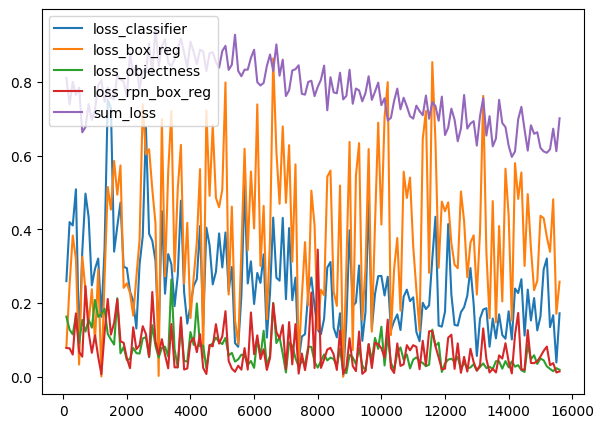

<module 'matplotlib.pyplot' from '/root/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [19]:
num_epochs = 26
visualizer.reset()

mean_loss = 0
model.train()
for epoch in range(num_epochs):
    for idx, (X, y) in enumerate(dl):
        optimizer.zero_grad()
        X = list(X)
        for i in range(len(X)):
            X[i] = X[i].to(device)
        for j in range(len(y)):
            y[j]['boxes'] = y[j]['boxes'].to(device)
            y[j]['labels'] = y[j]['labels'].to(device)
        loss_dict = model(X, y)
        loss = sum(loss_dict.values())
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        mean_loss += loss.item()
        if (idx + 1) % 100 == 0:
            print(f'epoch:{epoch + 1} iters: {epoch * len(dl) + idx + 1} train_loss: {mean_loss / 100:.4f}')
            visualizer.record(**{
                'iterations': epoch * len(dl) + idx + 1,
                'loss_classifier': loss_dict['loss_classifier'].cpu().item(),
                'loss_box_reg': loss_dict['loss_box_reg'].cpu().item(),
                'loss_objectness': loss_dict['loss_objectness'].cpu().item(),
                'loss_rpn_box_reg': loss_dict['loss_rpn_box_reg'].cpu().item(),
                'sum_loss': mean_loss / 100.0
            })
            mean_loss = 0
visualizer.visualize('iterations', [['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'sum_loss']])

In [20]:
from torchvision.utils import make_grid

In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrain=True)
# model.to('cuda')
# 1

In [21]:
CarlaDS.labels_int2str

{0: 'background',
 1: 'vehicle',
 2: 'pedestrian',
 3: 'traffic_light',
 4: 'traffic_sign'}

In [22]:
from torchvision import transforms

In [ ]:
model.eval()
for i in range(10):
    image_idx = i
    pred = model((valid_ds[image_idx][0].to(device),))[0]
    gt = valid_ds[image_idx][1]

    img_gt = draw_bbox_with_tensor(valid_ds[image_idx][0], gt['boxes'], [CarlaDS.labels_int2str[i.item()] for i in gt['labels']])
    img = draw_bbox_with_tensor(valid_ds[image_idx][0], pred['boxes'], [CarlaDS.labels_int2str[i.item()] for i in pred['labels']])
    transforms.ToPILImage()(make_grid([img_gt, img])).save(f'./detection_results/demo_{i}.jpg')

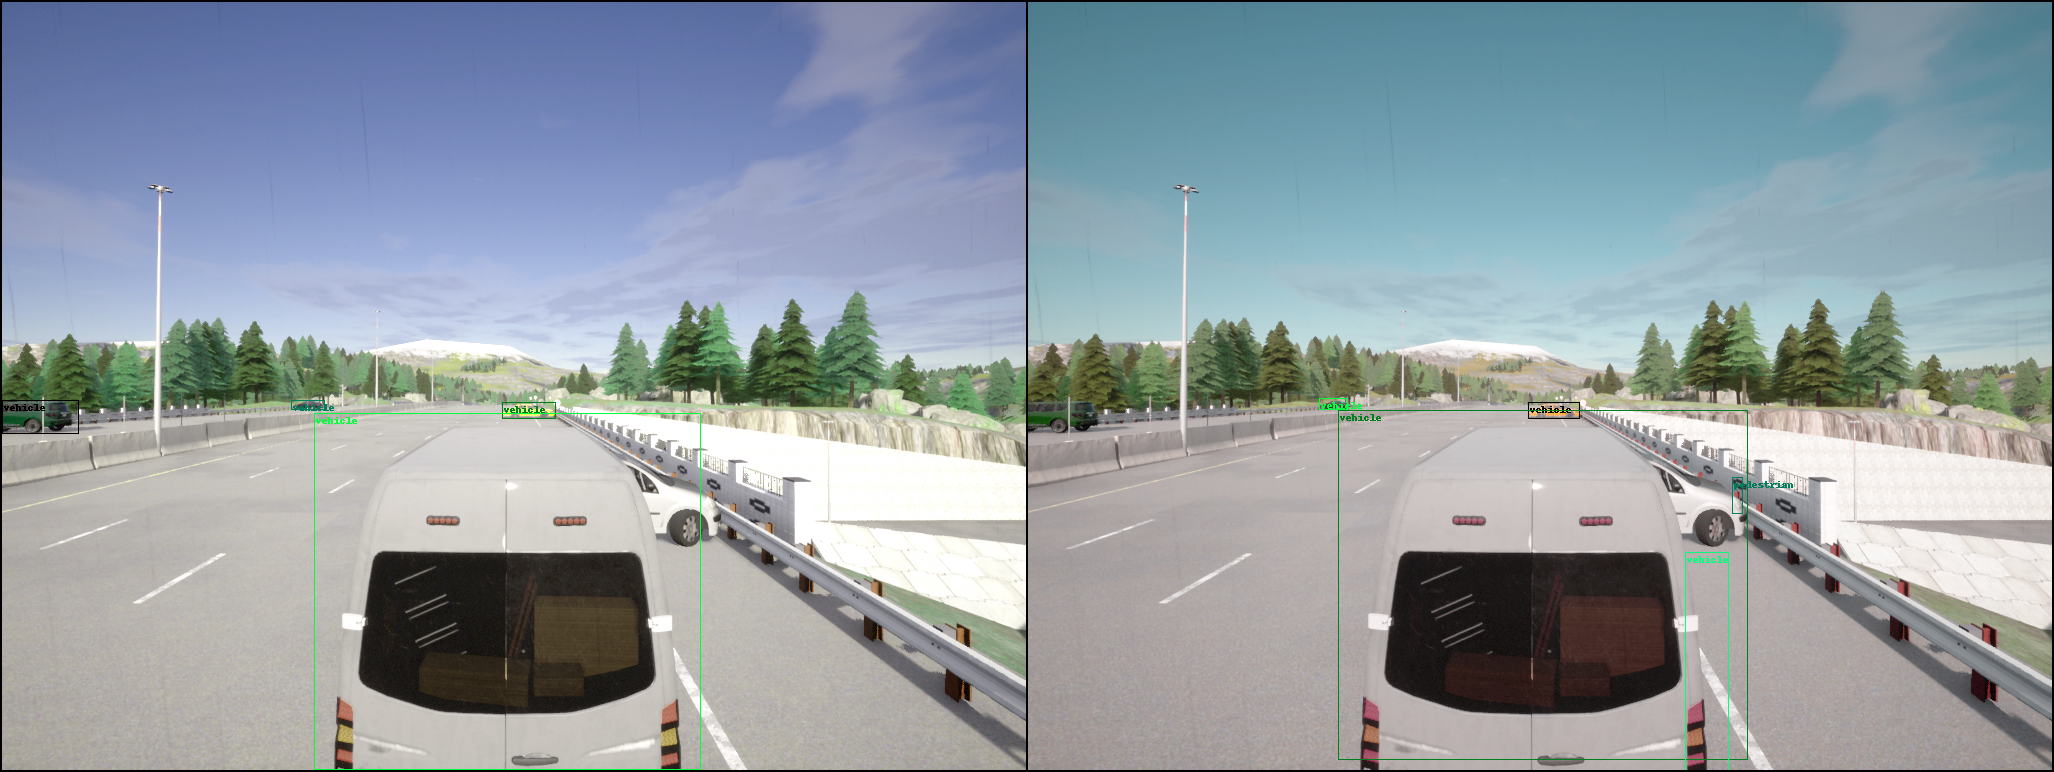

In [23]:
model.eval()
image_idx = 0
pred = model((valid_ds[image_idx][0].to(device),))[0]
gt = valid_ds[image_idx][1]

img_gt = draw_bbox_with_tensor(valid_ds[image_idx][0], gt['boxes'], [CarlaDS.labels_int2str[i.item()] for i in gt['labels']])
img = draw_bbox_with_tensor(valid_ds[image_idx][0], pred['boxes'], [CarlaDS.labels_int2str[i.item()] for i in pred['labels']])
transforms.ToPILImage()(make_grid([img_gt, img]))

In [27]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
MAP = MeanAveragePrecision()
with torch.no_grad():
    for i in range(300):
        img, target = valid_ds[i]
        pred = model(img.unsqueeze(0).to(device))[0]

        MAP.update([{key: pred[key].cpu() for key in pred.keys()}], [target])
        if (i + 1) % 100 == 0:
            print(f'processing {i + 1}/1000...')

processing 100/1000...
processing 200/1000...
processing 300/1000...


In [28]:
MAP.compute()

{'map': tensor(0.4637),
 'map_50': tensor(0.4985),
 'map_75': tensor(0.4735),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.1329),
 'map_large': tensor(0.4673),
 'mar_1': tensor(0.1952),
 'mar_10': tensor(0.4995),
 'mar_100': tensor(0.5000),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.2079),
 'mar_large': tensor(0.5040),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

In [ ]:
# model = torch.load('carla_detector.pt')

In [30]:
torch.save(model, 'fasterrcnn_resnet50_fpn_Carla.pt')

In [29]:
torch.save(MAP.compute(), 'valid_mAP.pt')